# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [200]:
import pandas as pd, matplotlib.pyplot as plt, matplotlib.patches as mpatches, numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [201]:
df = pd.read_csv('../data/checker_submits.csv', header=0, sep=',')

In [202]:
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

In [203]:
encoder = OneHotEncoder(sparse_output = False)
scaler = StandardScaler()

new_cols = []

encoded_uid = encoder.fit_transform(df[['uid']])
encoded_uid_df = pd.DataFrame(encoded_uid, columns=encoder.get_feature_names_out())

encoded_labname = encoder.fit_transform(df[['labname']])
encoded_labname_df = pd.DataFrame(encoded_labname, columns=encoder.get_feature_names_out())

scaled_x = scaler.fit_transform(df[['numTrials', 'hour']])
scaled_x_df = pd.DataFrame(scaled_x, columns=scaler.get_feature_names_out())

In [204]:
df = pd.concat([scaled_x_df, df.dayofweek, encoded_uid_df, encoded_labname_df], axis=1)

In [205]:
df.to_csv('../data/dayofweek.csv', index=False)

**Naive algorithm**

In [206]:
accuracy_score(df.dayofweek, np.full(len(df.dayofweek), df.dayofweek.mode()))

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [207]:
logreg = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear')

X_train = df.iloc[:, df.columns != 'dayofweek']
y_true = df.dayofweek

logreg.fit(X_train, y_true)

/Users/valeriyamaidanova/Documents/21school/DSBootcamp/day08/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,21
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [208]:
accuracy_score(y_true, logreg.predict(X_train))

0.6215895610913404

In [209]:
def plot_barh(model, top_n):
    match type(model).__name__:
        case 'LogisticRegression':
            model_coef = pd.DataFrame(model.coef_, columns=model.feature_names_in_)

        case 'OneVsRestClassifier':
            coefs = []
            for est in model.estimators_:
                coefs.append(*est.coef_)
            model_coef = pd.DataFrame(coefs, columns=model.feature_names_in_)

        case 'DecisionTreeClassifier':
            model_coef = pd.DataFrame(model.feature_importances_.reshape(1, 43), 
                                      columns=model.feature_names_in_)
            
        case 'RandomForestClassifier':
            coefs = []
            for est in model.estimators_:
                coefs.append(est.feature_importances_)
            model_coef = pd.DataFrame(coefs, columns=model.feature_names_in_)
            
    coef_sum = model_coef.abs().sum().sort_values(ascending=False)
    coef_sum[:top_n].plot.barh(y=coef_sum.index[:top_n])

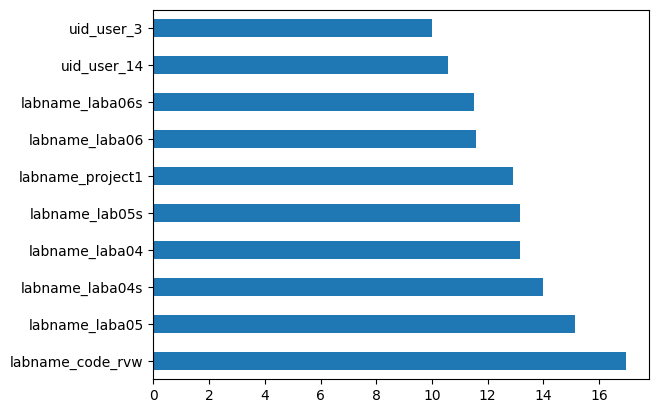

In [210]:
plot_barh(logreg, 10)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [211]:
def create_svc(kernel):
    svc = SVC(kernel=kernel, probability=True, random_state=21)
    svc.fit(X_train, y_true)
    return svc

def acc(model):
    print(accuracy_score(y_true, model.predict(X_train)))

In [212]:
svc1 = create_svc('linear')
acc(svc1)

0.702846975088968


In [213]:
svc2 = create_svc('poly')
acc(svc2)

0.8594306049822064


In [214]:
svc3 = create_svc('rbf')
acc(svc3)

0.8558718861209964


In [215]:
svc4 = create_svc('sigmoid')
acc(svc4)

0.3997627520759193


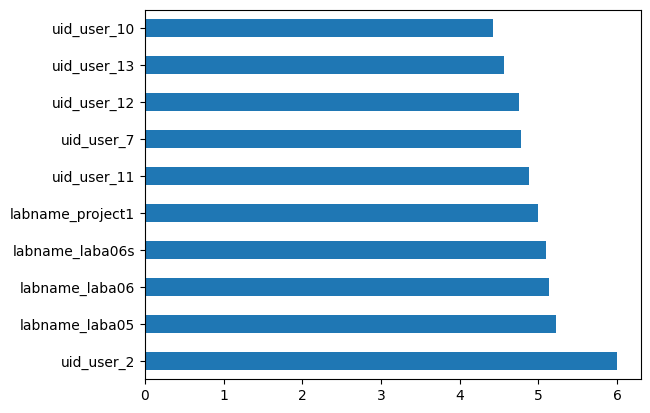

In [216]:
svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21)).fit(X_train, y_true)
plot_barh(svc, 10)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [217]:
def create_tree(n):
    tree = DecisionTreeClassifier(max_depth=n, random_state=21)
    tree.fit(X_train, y_true)
    return tree

In [218]:
tree1 = create_tree(7)
acc(tree1)

0.7064056939501779


In [219]:
tree2 = create_tree(1)
acc(tree2)

0.35765124555160144


In [220]:
tree3 = create_tree(10)
acc(tree3)

0.8196915776986952


In [221]:
tree = create_tree(4)

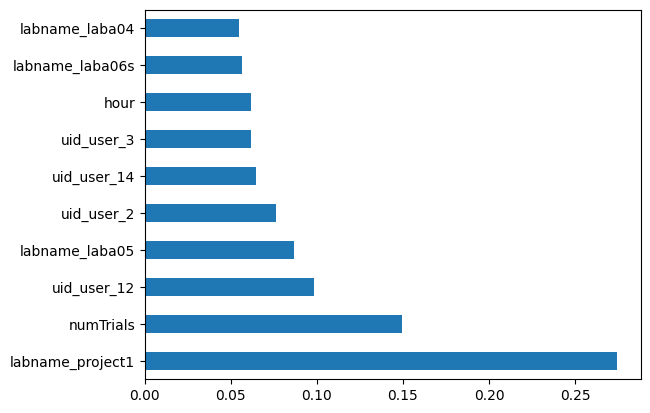

In [222]:
plot_barh(tree, 10)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [223]:
def create_forest(n, k):
    forest = RandomForestClassifier(n_estimators=n, max_depth=k, random_state=21)
    forest.fit(X_train, y_true)
    return forest

In [224]:
forest1 = create_forest(100, 4)
acc(forest1)

0.5219454329774614


In [225]:
forest2 = create_forest(100, 20)
acc(forest2)

0.99644128113879


In [226]:
forest3 = create_forest(50, 20)
acc(forest3)

0.9970344009489917


In [227]:
forest = create_forest(100, 25)

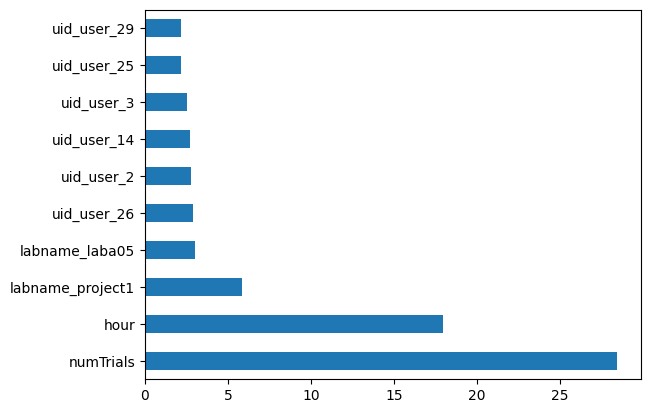

In [228]:
plot_barh(forest, 10)